In [6]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")

In [7]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from sqlalchemy import create_engine

In [60]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
        
    def buildModel(self,amount_time=60000):
        solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        
        W =self.bp.bins[0].width
        D =solver.NumVar(0,sum([max(w[i],d[i]) for i in range(n)]),"D")
        H =self.bp.bins[0].height

        #Mw=W+max(max(w),max(d))
        #Md=self.bp.bins[0].depth+max(max(w),max(d))
        #Mh=self.bp.bins[0].height+max(h)

        Mw=1000
        Md=1000
        Mh=1000

        
        print [self.bp.items[i].stackable for i in range(n)]
        
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        t =[[solver.IntVar(0,self.bp.items[i].stackable,"t%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        f =[[solver.IntVar(0,self.bp.items[i].stackable,"f%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        k =[[solver.BoolVar("k%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]
        z =[solver.NumVar(0,solver.infinity(),"z%d" % i) for i in range(n)]

        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] >= k[i][j])
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] <= 2 * k[i][j])
                    solver.Add(t[i][j] + t[j][i] == 1 - k[i][j])
                if(i != j):
                    solver.Add(x[i] - x[j] + w[i]*(1-r[i]) + d[i]*r[i] <= Mw  * (1 - l[i][j]))
                    solver.Add(x[i] - x[j] + d[i]*(1-r[i]) + w[i]*r[i] <= Md  * (1 - b[i][j]))
                    solver.Add(z[i] - z[j] + h[i] <= Mh * (1 - t[i][j]))
                    solver.Add(z[i] - z[j] + h[i] <= Mh * (1 - f[i][j]))
                    solver.Add(f[i][j] <= t[i][j])

            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)
            solver.Add(z[i] + h[i] <= H)

        for j in range(n):
            solver.Add(solver.Sum([f[i][j] for i in range(n) if i!=j]) * Mh >= z[j])
            
        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(300000)
        tm=time.time()
        solver.Solve()
        tm =time.time()-tm

        print [[[i,j] for j in range(n) if i != j and l[i][j].solution_value() == 1] for i in range(n)]
        print ""
        print [[[i,j] for j in range(n) if i != j and b[i][j].solution_value() == 1] for i in range(n)]
        print ""
        print [[[i,j] for j in range(n) if i != j and t[i][j].solution_value() == 1] for i in range(n)]
        print ""
        print [[[i,j] for j in range(n) if i != j and f[i][j].solution_value() == 1] for i in range(n)]
        print ""
        print [[[i,j] for j in range(n) if i != j and k[i][j].solution_value() == 0] for i in range(n)]
                
        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(x[i].solution_value(),y[i].solution_value(),z[i].solution_value()),rt,False)
        return s,tm,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [61]:
n_items = []
Avg_w = []
Avg_d = []
Avg_a = []
Time = []

In [62]:
for i in range(1):
    items,bins=BP_instances.tc_1()
    model = model_bin_packing(items,bins)
    s,t,w,d,h,n=model.buildModel()
    Time.append(round(t,3))
    Avg_w.append(round(sum(w)/n,3))
    Avg_d.append(round(sum(d)/n,3))
    Avg_a.append(round(sum([d[i]*w[i] for i in range(n)])/n,3))
    n_items.append(n)

[True, True, True, True, False, False]
[[[0, 1]], [], [[2, 1], [2, 3]], [], [[4, 5]], []]

[[], [], [[2, 0]], [], [[4, 3]], [[5, 1], [5, 3]]]

[[[0, 3], [0, 4], [0, 5]], [[1, 3], [1, 4]], [[2, 4], [2, 5]], [], [], []]

[[], [[1, 3]], [[2, 4], [2, 5]], [], [], []]

[[[0, 3], [0, 4], [0, 5]], [[1, 0], [1, 3], [1, 4]], [[2, 0], [2, 1], [2, 4], [2, 5]], [[3, 0], [3, 1], [3, 2]], [[4, 0], [4, 1], [4, 2], [4, 3]], [[5, 0], [5, 1], [5, 2], [5, 3], [5, 4]]]


In [65]:
BP_plot.plotSolution(s)

<IPython.core.display.Javascript object>


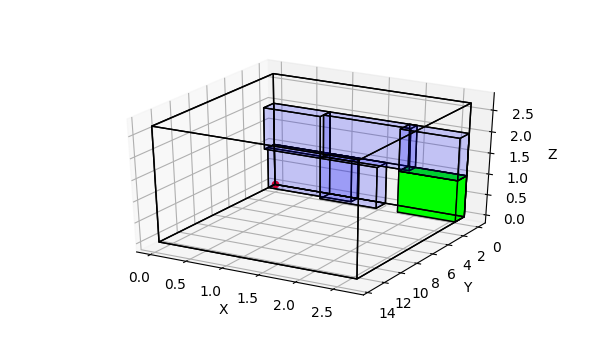

In [67]:
BP_plot.plot3DSolution(s,0,1)

In [ ]:
dimensioni =pd.DataFrame({'n_items': n_items, 'Avg Width': Avg_w, 'Avg Depth' : Avg_d, 'Avg Area': Avg_a, 'Time':Time})

In [ ]:
dimensioni.to_excel('result.xlsx', encoding='utf8')
dimensioni.to_latex('result.tex', encoding='utf8')
dimensioni.to_csv('result.csv', encoding='utf8')

In [ ]:
dimensioni